In [86]:
# Add pyWRspice location to system path, if you haven't run setup.py
import sys
sys.path.append("pyWRspice/")

In [113]:
import numpy as np
import logging, importlib
from pyWRspice.pyWRspice import script, simulation, remote

import matplotlib.pyplot as plt
%matplotlib inline
logging.basicConfig(level=logging.WARNING)

engine = simulation.WRWrapper(command = "/mnt/c/Users/pstark/xictools/wrspice/bin/wrspice") # Typical for Unix

In [134]:
dc_bias = """* DC Bias circuit
.model jj1 jj(level={level}, icrit={icrit_mag})
*i1 0 1 ac sin({i1_phase} {i1_mag} {i1_freq})
idc 0 1 {idc_mag}
l0 1 0 {l0_mag}
k1 l0 l1 {k1_mag}
l1 0 2 {l1_mag}
b1 2 0 101 jj1 ics={ics1_mag} phi={phi1_mag}
.tran {tran_step} {tran_stop} {tran_start} uic 
.control
set maxdata={maxdata}
run
set filetype=binary
write {output_file} i(l1) v(101)
.endc
"""

sw = simulation.WRWrapper(dc_bias, command = "/mnt/c/Users/pstark/xictools/wrspice/bin/wrspice")

In [135]:
params = {'level':1, 'icrit_mag': 1.0e-6, 'i1_phase': 0, 'i1_mag': 1e-9, 'i1_freq': 30e6, 'idc_mag': 1.06157895e-04,
          'l0_mag': 3e-12, 'k1_mag': 1, 'l1_mag': 3e-12, 'ics1_mag': 1.1e-6, 'phi1_mag': 0, 'ics2_mag': 2.2e-6, 'phi2_mag': 0,
          'l2_mag': 1e-10, 'tran_step': 1e-11, 'tran_stop': 6e-7, 'tran_start': 1e-7, 'maxdata': 1024000, 'output_file': None}
# Check the script before running
print(dc_bias.format(**params))

* DC Bias circuit
.model jj1 jj(level=1, icrit=1e-06)
*i1 0 1 ac sin(0 1e-09 30000000.0)
idc 0 1 0.000106157895
l0 1 0 3e-12
k1 l0 l1 1
l1 0 2 3e-12
b1 2 0 101 jj1 ics=1.1e-06 phi=0
.tran 1e-11 6e-07 1e-07 uic 
.control
set maxdata=1024000
run
set filetype=binary
write None i(l1) v(101)
.endc



In [136]:
%%time
# Run the script by passing the params to the run() method
dat2 = engine.run(dc_bias, **params)

# Extract the data
dat2 = dat2.to_array()
ts = dat2[0]
v2 = dat2[1]
v3 = dat2[2]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 20.8 s


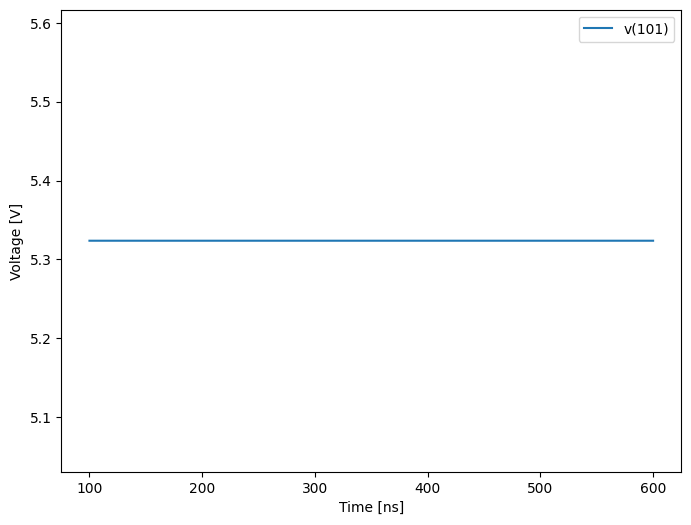

In [137]:
# Plot the data
fig = plt.figure(figsize=(8,6))
#plt.plot(ts*1e9, v2, label="@b1[phase]")
plt.plot(ts*1e9, v3%(2*np.pi), label="v(101)")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

### Now let's look at a range of parameters to see if the flux biasing works with an input flux signal

In [144]:
%%time
# Recycle params above
params["idc_mag"] = np.linspace(1e-6, 1e-2, 100)

params3, dat3 = engine.run_parallel(dc_bias, save_file=False, **params)

CPU times: user 15.6 ms, sys: 250 ms, total: 266 ms
Wall time: 3min 7s


In [145]:
params["idc_mag"]

array([1.000e-06, 1.020e-04, 2.030e-04, 3.040e-04, 4.050e-04, 5.060e-04,
       6.070e-04, 7.080e-04, 8.090e-04, 9.100e-04, 1.011e-03, 1.112e-03,
       1.213e-03, 1.314e-03, 1.415e-03, 1.516e-03, 1.617e-03, 1.718e-03,
       1.819e-03, 1.920e-03, 2.021e-03, 2.122e-03, 2.223e-03, 2.324e-03,
       2.425e-03, 2.526e-03, 2.627e-03, 2.728e-03, 2.829e-03, 2.930e-03,
       3.031e-03, 3.132e-03, 3.233e-03, 3.334e-03, 3.435e-03, 3.536e-03,
       3.637e-03, 3.738e-03, 3.839e-03, 3.940e-03, 4.041e-03, 4.142e-03,
       4.243e-03, 4.344e-03, 4.445e-03, 4.546e-03, 4.647e-03, 4.748e-03,
       4.849e-03, 4.950e-03, 5.051e-03, 5.152e-03, 5.253e-03, 5.354e-03,
       5.455e-03, 5.556e-03, 5.657e-03, 5.758e-03, 5.859e-03, 5.960e-03,
       6.061e-03, 6.162e-03, 6.263e-03, 6.364e-03, 6.465e-03, 6.566e-03,
       6.667e-03, 6.768e-03, 6.869e-03, 6.970e-03, 7.071e-03, 7.172e-03,
       7.273e-03, 7.374e-03, 7.475e-03, 7.576e-03, 7.677e-03, 7.778e-03,
       7.879e-03, 7.980e-03, 8.081e-03, 8.182e-03, 

In [146]:
# Extract data
idcs = params3["idc_mag"]
v2s = []
v3s = []
for dat in dat3:
    v2s.append(dat.to_array()[1])
    v3s.append(dat.to_array()[2])
ts = dat.to_array()[0]

Text(0, 0.5, 'JJ Flux (Rad)')

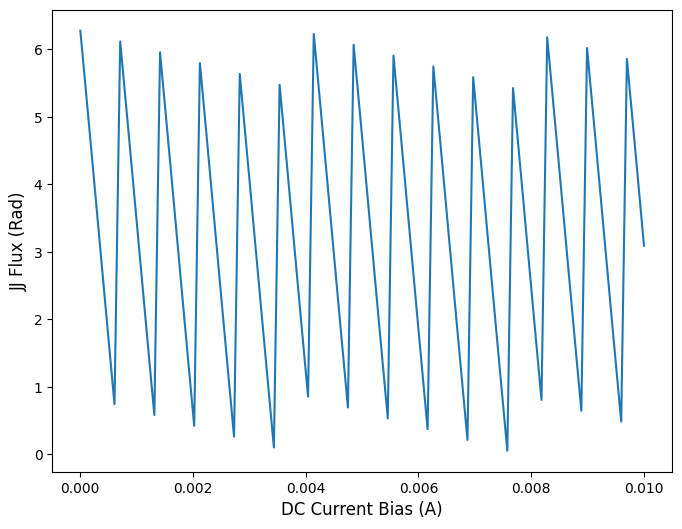

In [149]:
fig = plt.figure(figsize=(8,6))

bias, rad = [], []

for idc, v3 in zip(idcs, v3s):
    rad.append(v3[50]%(2*np.pi))
    bias.append(idc)

plt.plot(bias, rad)
plt.xlabel('DC Current Bias (A)', fontsize=12)
plt.ylabel('JJ Flux (Rad)', fontsize=12)

#plt.savefig('dc_bias_vs_flux.jpg', bbox_inches='tight')

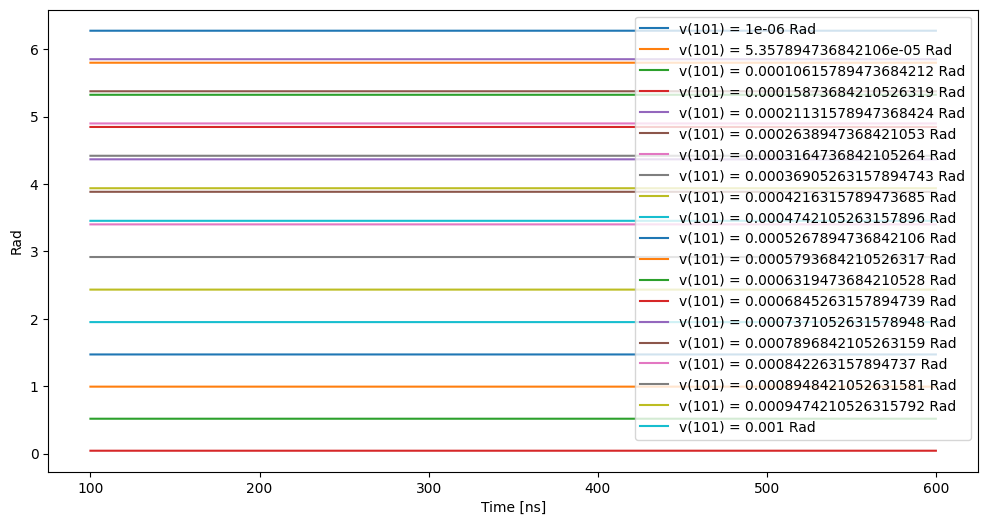

In [125]:
# Plot the data
fig = plt.figure(figsize=(12,6))
for idc, v3 in zip(idcs, v3s):
    plt.plot(ts*1e9, v3%(2*np.pi), label="v(101) = %s Rad" %idc)
plt.xlabel("Time [ns]")
plt.ylabel("Rad")
plt.legend()
plt.show()

### Let's compare the results to that of a step function input

In [126]:
dc_bias_step = """* DC Bias circuit
.model jj1 jj(level={level}, icrit={icrit_mag})
*i1 0 1 ac sin({i1_phase} {i1_mag} {i1_freq})
idc 0 1 pulse(0 {idc_mag} 3e-07 0 0 1e-07)
l0 1 0 {l0_mag}
k1 l0 l1 {k1_mag}
l1 0 2 {l1_mag}
b1 2 0 101 jj1 ics={ics1_mag} phi={phi1_mag}
.tran {tran_step} {tran_stop} {tran_start} uic 
.control
set maxdata={maxdata}
run
set filetype=binary
write {output_file} i(l1) v(101)
.endc
"""

sw = simulation.WRWrapper(dc_bias, command = "/mnt/c/Users/pstark/xictools/wrspice/bin/wrspice")

In [127]:
params = {'level':1, 'icrit_mag': 1.0e-6, 'i1_phase': 0, 'i1_mag': 1e-9, 'i1_freq': 30e6, 'idc_mag': 1.06157895e-04,
          'l0_mag': 3e-12, 'k1_mag': 1, 'l1_mag': 3e-12, 'ics1_mag': 1.1e-6, 'phi1_mag': 0, 'ics2_mag': 2.2e-6, 'phi2_mag': 0,
          'l2_mag': 1e-10, 'tran_step': 1e-11, 'tran_stop': 6e-7, 'tran_start': 1e-7, 'maxdata': 1024000, 'output_file': None}
# Check the script before running
print(dc_bias_step.format(**params))

* DC Bias circuit
.model jj1 jj(level=1, icrit=1e-06)
*i1 0 1 ac sin(0 1e-09 30000000.0)
idc 0 1 pulse(0 0.000106157895 3e-07 0 0 1e-07)
l0 1 0 3e-12
k1 l0 l1 1
l1 0 2 3e-12
b1 2 0 101 jj1 ics=1.1e-06 phi=0
.tran 1e-11 6e-07 1e-07 uic 
.control
set maxdata=1024000
run
set filetype=binary
write None i(l1) v(101)
.endc



In [128]:
%%time
# Run the script by passing the params to the run() method
dat3 = engine.run(dc_bias_step, **params)

# Extract the data
dat3 = dat3.to_array()
ts3 = dat3[0]
v23 = dat3[1]
v33 = dat3[2]

CPU times: user 0 ns, sys: 31.2 ms, total: 31.2 ms
Wall time: 21.7 s


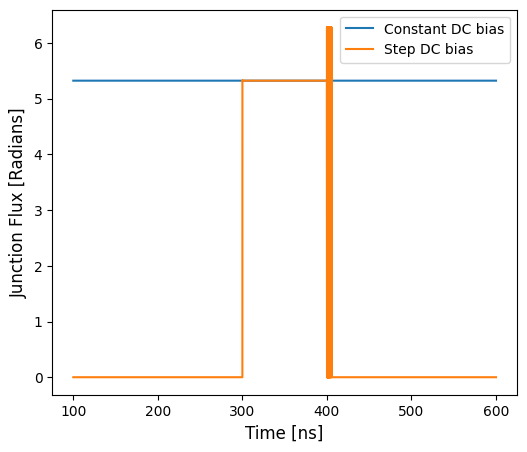

In [142]:
# Plot the data
fig = plt.figure(figsize=(6,5))
plt.plot(ts*1e9, v3%(2*np.pi), label="Constant DC bias")
plt.plot(ts3*1e9, v33%(2*np.pi), label="Step DC bias")
plt.xlabel("Time [ns]", fontsize=12)
plt.ylabel("Junction Flux [Radians]", fontsize=12)
plt.legend()
plt.savefig('dc_bias_test.jpg', bbox_inches='tight')
plt.show()

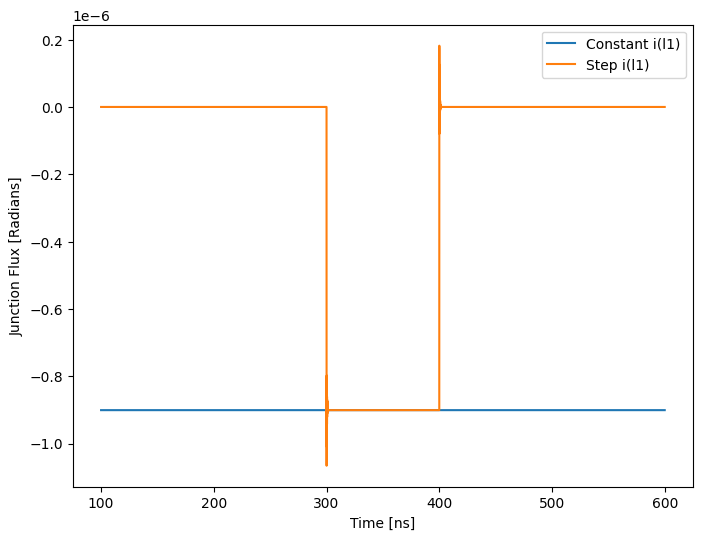

In [139]:
# Plot the data
fig = plt.figure(figsize=(8,6))
plt.plot(ts*1e9, v2, label="Constant i(l1)")
plt.plot(ts3*1e9, v23, label="Step i(l1)")
plt.xlabel("Time [ns]")
plt.ylabel("Junction Flux [Radians]")
plt.legend()
plt.show()